##### Intro

* Import pandas, numpy and csv
* load our data files
    * rand is field counts + analytics for a million items
        * 950,918 have no usage
        * remainider have usage ranging from 1 to 598
        * this is our main training set
    * evalu is a second 500k set for additional generalization evaluation
        * 475,853 0's, others up to 322
    * words here represents the full data set, with wordcounts
* Merge both data sets with words and do some cleanup; binarize analytics, etc
* Set up our features
    * x columns are field counts, y columns are row counts

In [2]:
import pandas as pd
import numpy as np
import csv as csv

In [6]:
rand = pd.read_csv('dpla.merged.rand.1m.csv', sep='|')
evalu = pd.read_csv('dpla.merged.rand.csv', sep='|')

In [4]:
words = pd.read_csv('words/wordcounts.csv', sep='|')

In [5]:
words = words.dropna(subset = ['dplaid'])

In [7]:
merge_rand = rand.merge(words, left_on='identifier', right_on='dplaid', how='left')
merge_eval = evalu.merge(words, left_on='identifier', right_on='dplaid', how='left')

In [9]:
# Approach to binarize analytics borrowed from: 
# http://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns
def binary (row):
    if row['analytics'] == 0 :
        return 0
    else:
        return 1

merge_rand.loc[:,'analyticsbin'] = merge_rand.apply (lambda row: binary (row),axis=1)
merge_eval.loc[:,'analyticsbin'] = merge_eval.apply (lambda row: binary (row),axis=1)

In [10]:
### Gotta decide if I want to try to encode provider here somehow...
### http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html
### For now, I'm dropping
featurelist = ['collection_x', 'contributor_x', 'creator_x', 'date_x',
             'description_x', 'extent_x', 'format_x', 'identifier.1', 'isPartOf_x',
             'language_x', 'publisher_x', 'relation_x', 'rights_x', 'spatial_x',
             'subject_x', 'temporal_x', 'title_x','type_x',
             'collection_y', 'contributor_y', 'creator_y', 'date_y',
             'description_y', 'extent_y', 'format_y', 'identifier_y', 'isPartOf_y',
             'language_y', 'publisher_y', 'relation_y', 'rights_y', 'spatial_y',
             'subject_y', 'temporal_y', 'title_y', 'type_y', 'total']

In [11]:
# Set up training, tuning, and testing splits
# Actually, I might need to rethink how these are grouped...
from sklearn.cross_validation import train_test_split
model, tune = train_test_split(merge_rand, test_size=0.33, random_state=42)
train, test = train_test_split(model, test_size=0.33, random_state=42)

In [236]:
# We're gonna use a Naive Bayes as a baseline
# Probably shouldn't be using Gaussian, though, as this data ain't normal...

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_pred = gnb.fit(train[featurelist], train["analyticsbin"]).predict(test[featurelist])
print("Number of mislabeled points out of a total %d points : %d"
      % (test.shape[0],(test["analyticsbin"] != y_pred).sum()))


Number of mislabeled points out of a total 221100 points : 22873


In [239]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, classification_report

from sklearn.externals import joblib

test_true = test["analyticsbin"]

print "Accuracy:"
print accuracy_score(test_true, gnb_pred)

print "\nAUC:"
print roc_auc_score(test_true, gnb_pred)

print "\nConfusion Matrix:"
print confusion_matrix(test_true, gnb_pred)

print "\nF1 Score:"
print f1_score(test_true, gnb_pred)

print "\nClassification Report:"
print classification_report(test_true, gnb_pred) 
#                            target_names=["Not Used", "Used"])

Accuracy:
0.896549072818

AUC:
0.549071823735

Confusion Matrix:
[[196445  13764]
 [  9109   1782]]

F1 Score:
0.134811060256

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.93      0.94    210209
          1       0.11      0.16      0.13     10891

avg / total       0.91      0.90      0.91    221100



In [15]:
# Clear up some memory?
# Hah -- That goes from 36% to 24%!!
del words
del rand
del evalu

In [17]:
# How about a Decision Tree, then!
# I've now selected my features above, and built my training and testing feature sets.
# So Now I can...
from sklearn.tree import DecisionTreeClassifier, export_graphviz

dt = DecisionTreeClassifier(min_samples_split=20, random_state=99, max_leaf_nodes=100)
dt.fit(train[featurelist], train["analyticsbin"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=100, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [18]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.20160519.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.20160519.dot", "-o", "dt.20160519.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [19]:
visualize_tree(dt, featurelist)

In [20]:
!dot -Tjpg dt.20160519.dot -o dt.20160519.jpg

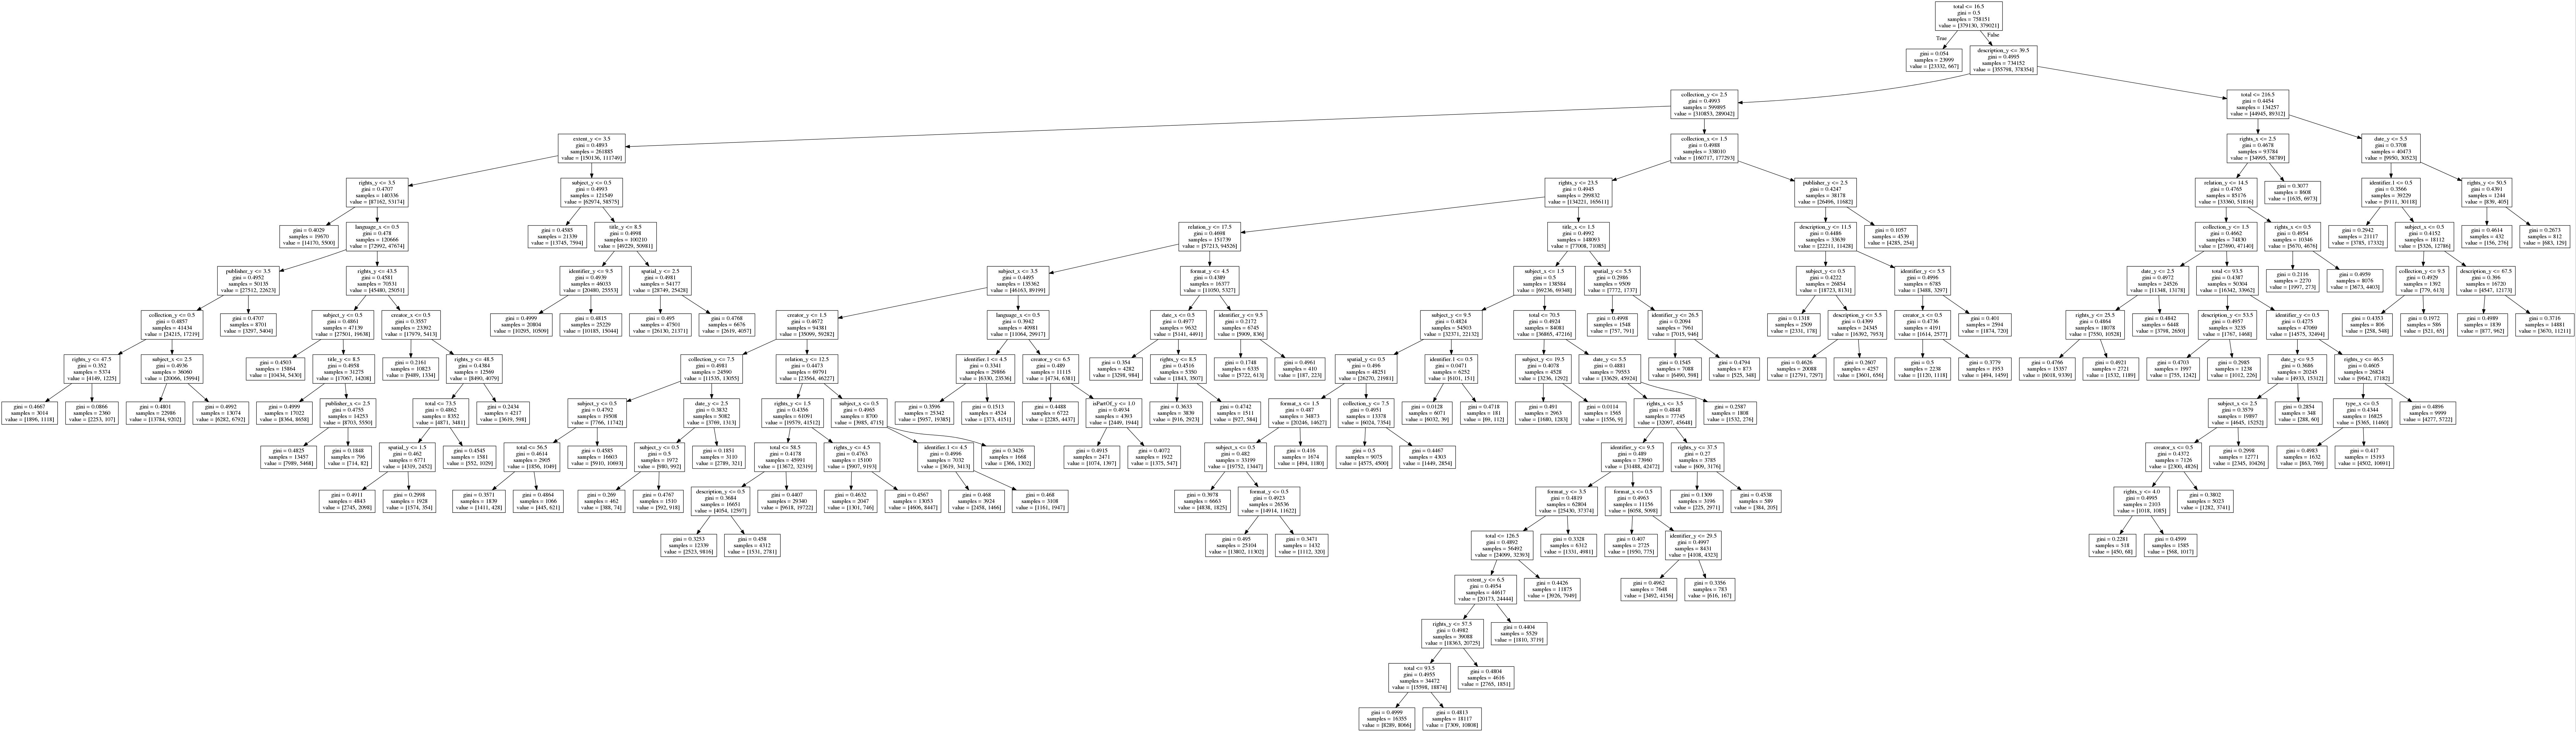

In [21]:
from IPython.display import Image
Image(filename='dt.jpg') 

In [22]:
dt.score(test[featurelist], test["analyticsbin"])

0.95091361374943462

In [23]:
dt.score(train[featurelist], train["analyticsbin"])

0.95130764089997777

In [240]:
# So let's actually look at our metrics on the Decision Tree:

from sklearn.metrics import confusion_matrix, f1_score, classification_report

tree_pred = dt.predict(test[featurelist])

print "Accuracy:"
print accuracy_score(test_true, tree_pred)

print "\nAUC:"
print roc_auc_score(test_true, tree_pred)

print "Confusion Matrix:"
print confusion_matrix(test_true, tree_pred)

print "F1 Score:"
print f1_score(test_true, tree_pred)

print "Classification Report:"
print classification_report(test_true, tree_pred) 
#                            target_names=["Not Used", "Used"])

Accuracy:
0.950913613749

AUC:
0.504138758206
Confusion Matrix:
[[210154     55]
 [ 10798     93]]
F1 Score:
0.0168493522964
Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    210209
          1       0.63      0.01      0.02     10891

avg / total       0.94      0.95      0.93    221100



#### Some initial evaluation thoughts

* Both our NB & our Tree have great accuracy and interestingly "above random" AUCs
* This is around where we started looking more closely at the confuse matrix and class reports
* F1 scores are very low. 
    * GNB has bad precision and recall on 1s
    * Tree has improved precision on 1s, but _terrible_ recall
* Still, we'd already spent some time on bagging, so keep going with that
    * Set up 7 trees with slightly diff min_samples_leaf
    * (This is based on code I wrote for Allstate Kaggle Competition some time ago)
    * (At that point, it felt like feature engineering was way more important than the actually classifier)
    * (But I got some feedback about these bags from and reworked later)

In [26]:
from sklearn import tree
adtree = tree.DecisionTreeClassifier(criterion = "entropy", min_samples_leaf = 50)
bdtree = tree.DecisionTreeClassifier(criterion = "entropy", min_samples_leaf = 50)
cdtree = tree.DecisionTreeClassifier(criterion = "entropy", min_samples_leaf = 100)
ddtree = tree.DecisionTreeClassifier(criterion = "entropy", min_samples_leaf = 100)
edtree = tree.DecisionTreeClassifier(criterion = "entropy", min_samples_leaf = 75)
fdtree = tree.DecisionTreeClassifier(criterion = "entropy", min_samples_leaf = 75)
gdtree = tree.DecisionTreeClassifier(criterion = "entropy", min_samples_leaf = 75)

In [27]:
from sklearn.ensemble import BaggingClassifier
abag = BaggingClassifier(base_estimator=adtree, n_estimators=30, n_jobs=-1)
bbag = BaggingClassifier(base_estimator=bdtree, n_estimators=30, n_jobs=-1)
cbag = BaggingClassifier(base_estimator=cdtree, n_estimators=30, n_jobs=-1)
dbag = BaggingClassifier(base_estimator=ddtree, n_estimators=30, n_jobs=-1)
ebag = BaggingClassifier(base_estimator=edtree, n_estimators=30, n_jobs=-1)
fbag = BaggingClassifier(base_estimator=fdtree, n_estimators=30, n_jobs=-1)
gbag = BaggingClassifier(base_estimator=gdtree, n_estimators=30, n_jobs=-1)

In [28]:
import warnings
warnings.filterwarnings('ignore')
print "Fitting abag"
abag.fit(train[featurelist], train["analyticsbin"])
print "Fitting bbag"
bbag.fit(train[featurelist], train["analyticsbin"])
print "Fitting cbag"
cbag.fit(train[featurelist], train["analyticsbin"])
print "Fitting dbag"
dbag.fit(train[featurelist], train["analyticsbin"])
print "Fitting ebag"
ebag.fit(train[featurelist], train["analyticsbin"])
print "Fitting fbag"
fbag.fit(train[featurelist], train["analyticsbin"])
print "Fitting gbag"
gbag.fit(train[featurelist], train["analyticsbin"])


Fitting abag
Fitting bbag
Fitting cbag
Fitting dbag
Fitting ebag
Fitting fbag
Fitting gbag


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=75,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=30, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [29]:
import warnings
warnings.filterwarnings('ignore')
print abag.score(test[featurelist], test["analyticsbin"])
print bbag.score(test[featurelist], test["analyticsbin"])
print cbag.score(test[featurelist], test["analyticsbin"])
print dbag.score(test[featurelist], test["analyticsbin"])
print ebag.score(test[featurelist], test["analyticsbin"])
print fbag.score(test[featurelist], test["analyticsbin"])


0.950904568069
0.950886476707
0.9507960199
0.950764360018
0.950863862506
0.950868385346


In [30]:
abag_pred = abag.predict(test[featurelist])
bbag_pred = abag.predict(test[featurelist])
cbag_pred = abag.predict(test[featurelist])
dbag_pred = abag.predict(test[featurelist])
ebag_pred = abag.predict(test[featurelist])
fbag_pred = abag.predict(test[featurelist])
gbag_pred = abag.predict(test[featurelist])

print "A Bag Classification Report:"
print classification_report(y_true, abag_pred) 

print "B Bag Classification Report:"
print classification_report(y_true, bbag_pred) 

print "C Bag Classification Report:"
print classification_report(y_true, cbag_pred) 

print "D Bag Classification Report:"
print classification_report(y_true, dbag_pred) 

print "E Bag Classification Report:"
print classification_report(y_true, ebag_pred) 

print "F Bag Classification Report:"
print classification_report(y_true, fbag_pred) 

print "G Bag Classification Report:"
print classification_report(y_true, gbag_pred) 

A Bag Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    210209
          1       0.69      0.01      0.01     10891

avg / total       0.94      0.95      0.93    221100

B Bag Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    210209
          1       0.69      0.01      0.01     10891

avg / total       0.94      0.95      0.93    221100

C Bag Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    210209
          1       0.69      0.01      0.01     10891

avg / total       0.94      0.95      0.93    221100

D Bag Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    210209
          1       0.69      0.01      0.01     10891

avg / total       0.94      0.95      0.93    221100

E Bag Classification Rep

In [265]:
# Rest of our metrics on abag

bag_pred = abag.predict(test[featurelist])

print "Accuracy:"
print accuracy_score(test_true, bag_pred)

print "\nAUC:"
print roc_auc_score(test_true, bag_pred)

print "Confusion Matrix:"
print confusion_matrix(test_true, bag_pred)

print "F1 Score:"
print f1_score(test_true, bag_pred)

print "Classification Report:"
print classification_report(test_true, bag_pred) 


Accuracy:
0.703188602442

AUC:
0.725501353907
Confusion Matrix:
[[147304  62905]
 [  2720   8171]]
F1 Score:
0.19937291837
Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.70      0.82    210209
          1       0.11      0.75      0.20     10891

avg / total       0.94      0.70      0.79    221100



In [241]:
# Experimenting with a Random Forrest instead
# My best previous were baggingclassifiers with min_samples_leaf = 50 
# Sticking with that, setting num features and also adding class_weight balanced.

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
#clf = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_split=1, random_state=0, max_features=17)
# Messing around with these params. Max features was recommended at 6 (square root of # features), but not much better
# Playing with min_samples_leaf because I had good luck playing with that before
# Currently at .70...
clf = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_leaf=50, 
                             random_state=0, max_features=6, class_weight="balanced")

scores = cross_val_score(clf, train[featurelist], train["analyticsbin"])

In [264]:
scores

array([ 0.76990524,  0.77081927,  0.76754459])

In [243]:
clf.fit(train[featurelist], train["analyticsbin"])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=6,
            max_leaf_nodes=None, min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [244]:
from sklearn.metrics import roc_auc_score
y_true = test["analyticsbin"]
#y_scores = abag.predict(test[featurelist])
yforrest_pred = clf.predict(test[featurelist])
roc_auc_score(y_true, yforrest_pred)

0.69505697915621112

In [245]:
### Precision, Recall, & f1 from Andy

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true, yforrest_pred)
print confusion

[[163688  46521]
 [  4232   6659]]


In [246]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, yforrest_pred)
print f1

0.207863151816


In [247]:
from sklearn.metrics import classification_report
print(classification_report(y_true, yforrest_pred,
                            target_names=["not used", "used"]))

             precision    recall  f1-score   support

   not used       0.97      0.78      0.87    210209
       used       0.13      0.61      0.21     10891

avg / total       0.93      0.77      0.83    221100



#### Comparing bag to rando forest

* At this point, we're not much different than abag
* We're sacrificing a tiny bit off AUC for a slight improvement in f1
* This is based on a negligable bump in used precision.
* Now we can plot our AUCs, too. Is that useful?

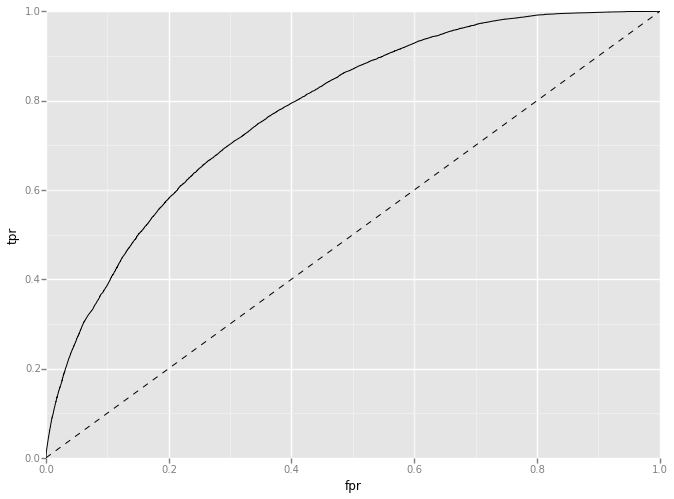

<ggplot: (8732022747301)>

In [52]:
%matplotlib inline  

# Cool beans. This seems to work? 
# http://blog.yhat.com/posts/roc-curves.html
# Requires a ggplot python port:
# https://github.com/yhat/ggplot

from sklearn import metrics
import pandas as pd
from ggplot import *

preds = clf.predict_proba(test[featurelist])[:,1]
fpr, tpr, _ = metrics.roc_curve(test["analyticsbin"], preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

#### Also compare to older abag

* This is from our artificially balanced data set
    * 1.1M recs, split 565k / 565k used vs not used.
    * Used counts went up to 839
* I pulled the loading/training of this out since I moved to natural data
* saved the model, though, for comparison's sake
* Also doing some comparison to dummy classifiers
    * One that predicts the most frequent item
    * One that predicts at random based on the percentages

In [32]:
from sklearn.externals import joblib
filename = 'abag-rand.pkl'
_ = joblib.dump(abag, filename, compress=9)

In [54]:
# Hmmm. So those aren't super good. 
# Let's check it compared to dummy's

# This is the majroity predict.

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report

dummy_majority = DummyClassifier(strategy='most_frequent').fit(train[featurelist], train["analyticsbin"])
y_dummy_maj = dummy_majority.predict(test[featurelist])
y_true = test["analyticsbin"]

print "Confusion Matrix:"
print confusion_matrix(y_true, y_dummy_maj)

print "F1 Score:"
print f1_score(y_true, y_dummy_maj)

print "Classification Report:"
print classification_report(y_true, y_dummy_maj) 
#                            target_names=["Not Used", "Used"])

Confusion Matrix:
[[210209      0]
 [ 10891      0]]
F1 Score:
0.0
Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    210209
          1       0.00      0.00      0.00     10891

avg / total       0.90      0.95      0.93    221100



In [55]:
# How about an actually dummy classifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report

dummy = DummyClassifier().fit(train[featurelist], train["analyticsbin"])
y_dummy = dummy.predict(test[featurelist])
y_true = test["analyticsbin"]

print "Confusion Matrix:"
print confusion_matrix(y_true, y_dummy)

print "F1 Score:"
print f1_score(y_true, y_dummy)

print "Classification Report:"
print classification_report(y_true, y_dummy) 
#                            target_names=["Not Used", "Used"])

Confusion Matrix:
[[199865  10344]
 [ 10329    562]]
F1 Score:
0.0515667293664
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.95      0.95    210209
          1       0.05      0.05      0.05     10891

avg / total       0.91      0.91      0.91    221100



In [56]:
#And for further comparison, a logisitc regression


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report

logreg = LogisticRegression(C=0.1).fit(train[featurelist], train["analyticsbin"])
y_logreg = logreg.predict(test[featurelist])
y_true = test["analyticsbin"]

print "Confusion Matrix:"
print confusion_matrix(y_true, y_logreg)

print "F1 Score:"
print f1_score(y_true, y_logreg)

print "Classification Report:"
print classification_report(y_true, y_logreg) 
#                            target_names=["Not Used", "Used"])


Confusion Matrix:
[[210106    103]
 [ 10837     54]]
F1 Score:
0.0097755249819
Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    210209
          1       0.34      0.00      0.01     10891

avg / total       0.92      0.95      0.93    221100



In [57]:
# What about balanced class-weight for the regression?


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report

logreg = LogisticRegression(C=0.1, class_weight='balanced').fit(train[featurelist], train["analyticsbin"])
y_logreg = logreg.predict(test[featurelist])
y_true = test["analyticsbin"]

print "Confusion Matrix:"
print confusion_matrix(y_true, y_logreg)

print "F1 Score:"
print f1_score(y_true, y_logreg)

print "Classification Report:"
print classification_report(y_true, y_logreg) 
#                            target_names=["Not Used", "Used"])

Confusion Matrix:
[[134866  75343]
 [  4247   6644]]
F1 Score:
0.143069402873
Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.64      0.77    210209
          1       0.08      0.61      0.14     10891

avg / total       0.93      0.64      0.74    221100



In [12]:
from sklearn.externals import joblib
filename = 'dummy.pkl'
_ = joblib.dump(dummy_majority, filename, compress=9)

#### Thresholds and operational points

* In the next two examples, we're reviewing a few plots
    * An ROC Curve
    * A Precision Recall Curve
* This tries to tell us where our optium points are on those curves
* But all of this is still built on a threshold of .5, which is the probability we're using to predict.
* What we'd like to do next is look at moving that probability to optimize for a value like f1

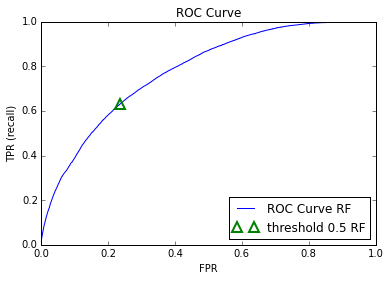

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true, clf.predict_proba(test[featurelist])[:, 1])

plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("ROC Curve")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10, 
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)

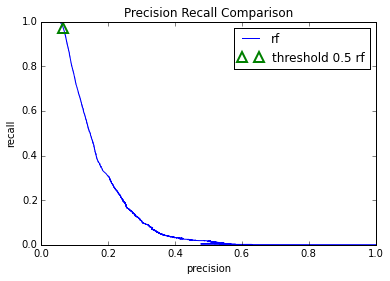

In [164]:
from sklearn.metrics import precision_recall_curve

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true, clf.predict_proba(test[featurelist])[:, 1])

plt.plot(precision_rf, recall_rf, label="rf")

plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 rf", fillstyle="none", c='k', mew=2)
plt.xlabel("precision")
plt.ylabel("recall")
plt.legend(loc='best')
plt.title("Precision Recall Comparison")

#### Probability threshold experiment

* So let's look for the optimum 
* Loop through with a cutoff probability of 0 to 1, using increments of .01
* Predict Used vs Not Used at each probability, then check the f-measure
* Plot them

        So, if I say "Used" every time I think the probability of used is greater than .01  
        Then greater than .02, .03, etc  
        
* It seems to maximize f1 at .32
    * If you're more than 32% sure it's a 0, predict 0, otherwise 1
    * This essentially uses our existing model, but favors predicting _not used_
    
            Note that you can optimize for any metric  
            F1, Precision, Recall, whatevs...

In [250]:
from sklearn.metrics import recall_score, precision_score
y = clf.predict_proba(test[featurelist])
# This tells us whether we're optimizing for 0 or 1.
prob_zero=y[:,0]
#Okay, so this whole damn sequence builds the same prediction loop as what I'd normally have?

threshes = []
f1s = []

#for x in np.arange(0,1,0.01):
for x in [x * 0.01 for x in range(0, 100)]:
    #print x
    threshes.append(x)
    pred = [0 if y > x else 1 for y in prob_zero]
    pred_asnd = np.asarray(pred)
    #print x, f1_score(y_true, pred_asnd)
    #recall_score(y_true, pred_asnd)
    f1s.append(f1_score(y_true, pred_asnd))


#pred_asnd = np.asarray(pred)
#f1_score(y_true, pred_asnd)

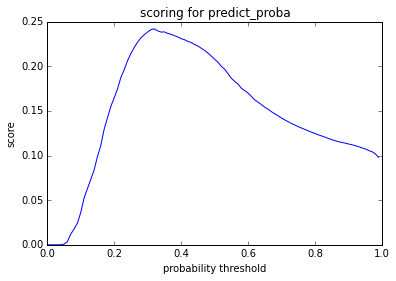

In [251]:
plt.plot(threshes, f1s)

plt.xlabel("probability threshold")
plt.ylabel("score")
#plt.legend(loc='best')
plt.title("scoring for predict_proba")

In [159]:
y = clf.predict_proba(test[featurelist])
prob_zero=y[:,0]
#Okay, so this whole damn sequence builds the same prediction loop as what I'd normally have?
pred = [0 if x > 0.32 else 1 for x in prob_zero]
pred_asnd = np.asarray(pred)

print yforrest_pred.shape
print pred_asnd.shape
print np.array_equal(yforrest_pred,pred_asnd)

(221100,)
(221100,)
False


In [160]:
# Here, we're sticking with our balanced class-weight random forrest
# And saying we need 32% or higher confidence to say 0, otherwise 1
# This seems to give the best results.
# But I wonder how I could plot those damned values. 


from sklearn.metrics import confusion_matrix, f1_score, classification_report


print "Confusion Matrix:"
print confusion_matrix(y_true, pred_asnd)

print "F1 Score:"
print f1_score(y_true, pred_asnd)

print "Classification Report:"
print classification_report(y_true, pred_asnd) 
#                            target_names=["Not Used", "Used"])

Confusion Matrix:
[[197559  12650]
 [  7633   3258]]
F1 Score:
0.243143400873
Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.94      0.95    210209
          1       0.20      0.30      0.24     10891

avg / total       0.93      0.91      0.92    221100



In [130]:
#### Compare this to our 50% threshold values

print "Confusion Matrix:"
print confusion_matrix(y_true, yforrest_pred)

print "F1 Score:"
print f1_score(y_true, yforrest_pred)

print "Classification Report:"
print classification_report(y_true, yforrest_pred) 
#                            target_names=["Not Used", "Used"])

Confusion Matrix:
[[160400  49809]
 [  4013   6878]]
F1 Score:
0.203557370742
Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.76      0.86    210209
          1       0.12      0.63      0.20     10891

avg / total       0.93      0.76      0.82    221100



In [252]:
## Evaluate the 32% on our holdout data

holdout = tune

hold_true = holdout["analyticsbin"]

y_hold = clf.predict_proba(holdout[featurelist])
prob_hold_zero=y_hold[:,0]
#Okay, so this whole damn sequence builds the same prediction loop as what I'd normally have?
pred_hold = [0 if x > 0.32 else 1 for x in prob_hold_zero]
pred_hold_asnp = np.asarray(pred_hold)

print "AUC:"
print roc_auc_score(hold_true, pred_hold_asnp)

print "Confusion Matrix:"
print confusion_matrix(hold_true, pred_hold_asnp)

print "F1 Score:"
print f1_score(hold_true, pred_hold_asnp)

print "Classification Report:"
print classification_report(hold_true, pred_hold_asnp) 
#                            target_names=["Not Used", "Used"])

AUC:
0.620805483484
Confusion Matrix:
[[295177  18629]
 [ 11320   4874]]
F1 Score:
0.245560117893
Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.94      0.95    313806
          1       0.21      0.30      0.25     16194

avg / total       0.93      0.91      0.92    330000



In [193]:
from sklearn.metrics import roc_auc_score

roc_auc_score(hold_true, pred_hold_asnp, average='weighted')

0.61924881637661

In [182]:
# How about an actually dummy classifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report

dummy = DummyClassifier().fit(holdout[featurelist], holdout["analyticsbin"])
hold_dummy = dummy.predict(holdout[featurelist])

print "Confusion Matrix:"
print confusion_matrix(hold_true, hold_dummy)

print "F1 Score:"
print f1_score(hold_true, hold_dummy)

print "Classification Report:"
print classification_report(hold_true, hold_dummy) 
#                            target_names=["Not Used", "Used"])

Confusion Matrix:
[[298561  15245]
 [ 15427    767]]
F1 Score:
0.0476308762342
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.95      0.95    313806
          1       0.05      0.05      0.05     16194

avg / total       0.91      0.91      0.91    330000



Feature ranking:
1. feature 36 (0.113245)
2. feature 22 (0.086540)
3. feature 30 (0.063029)
4. feature 34 (0.057273)
5. feature 32 (0.056207)
6. feature 18 (0.053083)
7. feature 14 (0.052737)
8. feature 20 (0.039924)
9. feature 25 (0.038464)
10. feature 21 (0.036790)
11. feature 29 (0.034873)
12. feature 12 (0.029648)
13. feature 7 (0.027383)
14. feature 28 (0.026653)
15. feature 24 (0.026430)
16. feature 31 (0.025236)
17. feature 4 (0.022515)
18. feature 23 (0.022216)
19. feature 13 (0.016649)
20. feature 11 (0.016102)
21. feature 0 (0.015797)
22. feature 9 (0.015416)
23. feature 27 (0.015219)
24. feature 6 (0.014779)
25. feature 2 (0.013314)
26. feature 19 (0.010672)
27. feature 16 (0.010644)
28. feature 26 (0.008205)
29. feature 10 (0.007602)
30. feature 3 (0.007236)
31. feature 15 (0.006058)
32. feature 1 (0.005788)
33. feature 35 (0.005634)
34. feature 5 (0.005257)
35. feature 33 (0.005031)
36. feature 8 (0.004430)
37. feature 17 (0.003923)


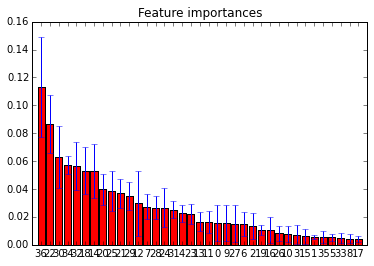

In [253]:
# Let's have a look at our most important features!!

# Cool: Taken from here:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train[featurelist].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train[featurelist].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train[featurelist].shape[1]), indices)
plt.xlim([-1, train[featurelist].shape[1]])
plt.show()

In [261]:
total = 0
count = 0
for f in range(train[featurelist].shape[1]):
    if count < 7:
        count = count + 1
        print indices[f]
        total = total + importances[indices[f]]

print total

36
22
30
34
32
18
14
0.482114677224


0  'collection_x', 
1  'contributor_x', 
2  'creator_x', 
3  'date_x',
4  'description_x', 
5  'extent_x', 
6  'format_x', 
7  'identifier.1', 
8  'isPartOf_x',
9  'language_x', 
10 'publisher_x', 
11 'relation_x', 
12 'rights_x', 
13 'spatial_x',
14 'subject_x', 
15 'temporal_x', 
16 'title_x',
17 'type_x',
18 'collection_y', 
19 'contributor_y', 
20 'creator_y', 
21 'date_y',
22 'description_y', 
23 'extent_y', 
24 'format_y', 
25 'identifier_y', 2
26 'isPartOf_y',
27 'language_y', 
28 'publisher_y', 
29 'relation_y', 
30 'rights_y', 
31 'spatial_y',
32 'subject_y', 
33 'temporal_y', 
34 'title_y', 
35 'type_y', 
36 'total']

In [235]:
# check the abag on the eval data set.

from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib

abag = joblib.load('abag.pkl')

eval_true = merge_eval["analyticsbin"]
eval_pred_old = abag.predict(merge_eval[featurelist])

print "Accuracy:"
print accuracy_score(eval_true, eval_pred_old)

print "\nAUC:"
print roc_auc_score(eval_true, eval_pred_old)

print "\nConfusion Matrix:"
print confusion_matrix(eval_true, eval_pred_old)

print "\nF1 Score:"
print f1_score(eval_true, eval_pred_old)

print "\nClassification Report:"
print classification_report(eval_true, eval_pred_old) 
#                            target_names=["Not Used", "Used"])

Accuracy:
0.704552

AUC:
0.729144951587

Confusion Matrix:
[[334012 141841]
 [  5883  18264]]

F1 Score:
0.198250222521

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.70      0.82    475853
          1       0.11      0.76      0.20     24147

avg / total       0.94      0.70      0.79    500000



In [254]:
# Check the 32% on our evalu data set.

from sklearn.metrics import accuracy_score

eval_proba = clf.predict_proba(merge_eval[featurelist])
eval_proba_zero=eval_proba[:,0]
#Okay, so this whole damn sequence builds the same prediction loop as what I'd normally have?
eval_pred_tmp = [0 if x > 0.32 else 1 for x in eval_proba_zero]
pred_pred_new = np.asarray(eval_pred_tmp)

print "Accuracy:"
print accuracy_score(eval_true, pred_pred_new)

print "\nAUC:"
print roc_auc_score(eval_true, pred_pred_new)

print "\nConfusion Matrix:"
print confusion_matrix(eval_true, pred_pred_new)

print "\nF1 Score:"
print f1_score(eval_true, pred_pred_new)

print "\nClassification Report:"
print classification_report(eval_true, pred_pred_new) 
#                            target_names=["Not Used", "Used"])

Accuracy:
0.909846

AUC:
0.619666986052

Confusion Matrix:
[[447716  28137]
 [ 16940   7207]]

F1 Score:
0.242288749559

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.94      0.95    475853
          1       0.20      0.30      0.24     24147

avg / total       0.93      0.91      0.92    500000



In [263]:
# And let's just double check our gnb on that second evalu dataset.

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, classification_report

from sklearn.externals import joblib

eval_gnb_pred = gnb.fit(merge_eval[featurelist], merge_eval["analyticsbin"]).predict(merge_eval[featurelist])


print "Accuracy:"
print accuracy_score(eval_true, eval_gnb_pred)

print "\nAUC:"
print roc_auc_score(eval_true, eval_gnb_pred)

print "\nConfusion Matrix:"
print confusion_matrix(eval_true, eval_gnb_pred)

print "\nF1 Score:"
print f1_score(eval_true, eval_gnb_pred)

print "\nClassification Report:"
print classification_report(eval_true, eval_gnb_pred) 
#                            target_names=["Not Used", "Used"])

Accuracy:
0.912126

AUC:
0.53848753927

Confusion Matrix:
[[453047  22806]
 [ 21131   3016]]

F1 Score:
0.120714843203

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.95      0.95    475853
          1       0.12      0.12      0.12     24147

avg / total       0.91      0.91      0.91    500000

